In [46]:
import os

from keras import Input
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Lambda, Flatten, Dense
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.optimizers import Adam
import numpy as np
import cv2
from matplotlib import pyplot as plt

from file_handler import handler

In [47]:
val_data_proportion = 1 / 6
#
nb_images = 15
#a
start_val_data_idx = int(nb_images * (1 - val_data_proportion))

#
data_dir = 'resources/after_processing'
#
image_example = 'resources/proc_data/train_data/false-0.jpg'
# Директория с данными для обучения
train_dir = 'train'
train_true_dir = f'{train_dir}/true'
train_false_dir = f'{train_dir}/false'
# Директория с данными для проверки
val_dir = 'val'
# Директория с данными для тестирования
test_dir = 'test'

input_shape = (64, 128, 1)

In [48]:
handler.train_data_preparation()
handler.data_processing(dir_name=train_dir, start_index=0, end_index=start_val_data_idx)
handler.data_processing(dir_name=val_dir, start_index=start_val_data_idx, end_index=nb_images)
handler.adding_test_data(dir_name=test_dir, count_files=2, create_new_dir=True)

In [49]:
def image_preparation(img: str) -> np.array:
    image = cv2.imread(img)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    boxes = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        boxes.append([x,y, x+w,y+h])
    boxes = np.asarray(boxes)
    left = np.min(boxes[:,0])
    top = np.min(boxes[:,1])
    right = np.max(boxes[:,2])
    bottom = np.max(boxes[:,3])

    result[close==0] = (255,255,255)
    ROI = result[top:bottom, left:right].copy()
    ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)

    retval, thresh_crop = cv2.threshold(ROI, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    fin = cv2.resize(thresh_crop, (64, 128))
    return fin

In [50]:
def make_paris(path: str) -> np.array:
    true_images = list(map(lambda image: f"{path}/true/{image}", list(os.walk(f"{path}/true/"))[0][2]))
    false_images = list(map(lambda image: f"{path}/false/{image}", list(os.walk(f"{path}/false/"))[0][2]))
    x_paris = []
    y_paris = []
    false_iterator = 0
    list_iterator = 0
    if len(true_images) % 3 != 0:
        raise Exception('Количество подлинных подписей должно быть кратно 3')
    for i in range(len(true_images)):
        if i % 3 == 0:
            x_paris.append([image_preparation(true_images[i])])
        if i % 3 == 1:
            x_paris[list_iterator].append(image_preparation(true_images[i]))
            list_iterator += 1
            y_paris.append(1)
        if i % 3 == 2:
            x_paris.append([image_preparation(true_images[i]), image_preparation(false_images[false_iterator])])
            false_iterator += 1
            list_iterator += 1
            y_paris.append(0)

    return np.array(x_paris).reshape(len(x_paris), 2, *input_shape), np.array(y_paris)

In [51]:
X_train, Y_train = make_paris(train_dir)
X_val, Y_val = make_paris(val_dir)

In [52]:
def initialize_weights(shape, dtype=None):
  return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype=None):
  return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [53]:
def network(input_shape):
    # Определение тензоров для двух изображение
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # CNN
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights,
                   bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (2,2), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(2e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))

    # Создание векторов двух объектов
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Добавление слоя, для вычисления абсолютной разницы между кодировками
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Добавление слоя с сигмовидной единицей измерения, для получения оценки сходства
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)

    # Объединение входов и выходов
    my_model = Model(inputs=[left_input,right_input],outputs=prediction)

    return my_model

In [60]:
model = network(input_shape)
model.summary()
optimizer = Adam(learning_rate=0.00005)
model.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
history_snn = model.fit(
    [X_train[:,0], X_train[:,1]],
    Y_train,
    batch_size=1,
    epochs=6,
    validation_data=([X_val[:,0], X_val[:,1]], Y_val)
  )

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 64, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_18 (InputLayer)          [(None, 64, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential_8 (Sequential)      (None, 4096)         21777216    ['input_17[0][0]',               
                                                                  'input_18[0][0]']         

In [61]:
test_true_0 = 'test/true/true-0.jpg'
test_true_1 = 'test/true/true-1.jpg'
test_false_0 = 'test/false/false-0.jpg'
test_false_1 = 'test/false/false-1.jpg'

In [62]:
def match_sign(img1, img2):
    x = np.array([
        image_preparation(img1),
        image_preparation(img2),
    ]).reshape((1, 2, *input_shape))
    y_pred_1 = x[:, 0]
    y_pred_2 = x[:, 1]

    inputs = [y_pred_1, y_pred_2]

    ## Прогнозирование
    pred = model.predict(inputs)
    pred_score = pred[0][0]
    pred_class = pred_score >= 0.80
    print("Предсказание: {} => {}".format(pred_score, pred_class))

    ## Отрисовка изображений
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax[0].imshow(cv2.imread(img1))
    ax[1].imshow(cv2.imread(img2))
    ax[0].set_title("Подпись-1")
    ax[1].set_title("Подпись-2")
    plt.show()
    plt.close()

1/1 [==============================] - 0s 75ms/step
Предсказание: 0.5129215717315674 => False


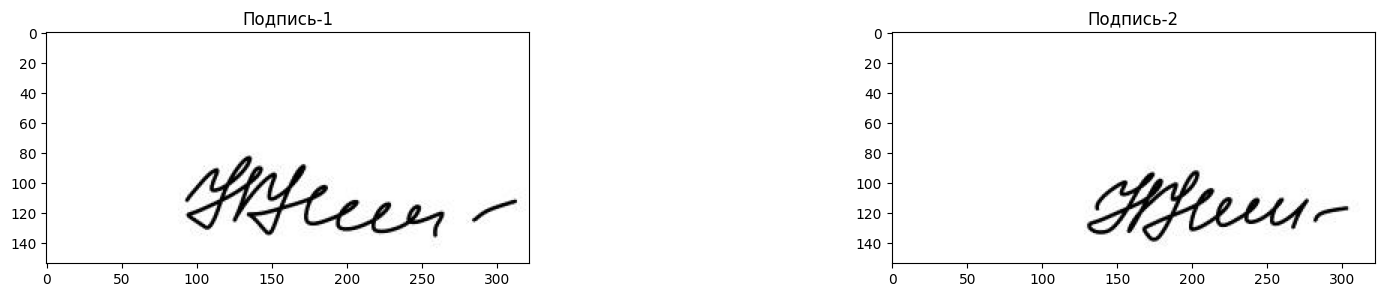

In [63]:
match_sign(test_true_0, test_true_1)

1/1 [==============================] - 0s 24ms/step
Предсказание: 0.0051727513782680035 => False


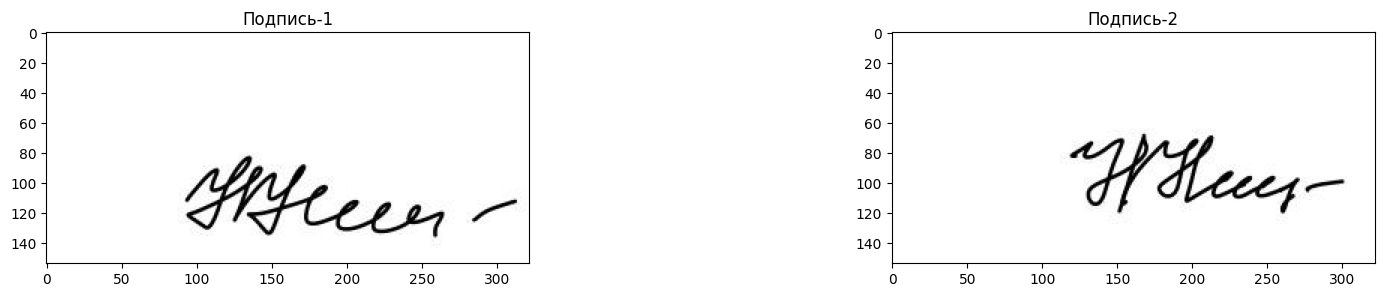

In [64]:
match_sign(test_true_0, test_false_1)

1/1 [==============================] - 0s 34ms/step
Предсказание: 0.05259857699275017 => False


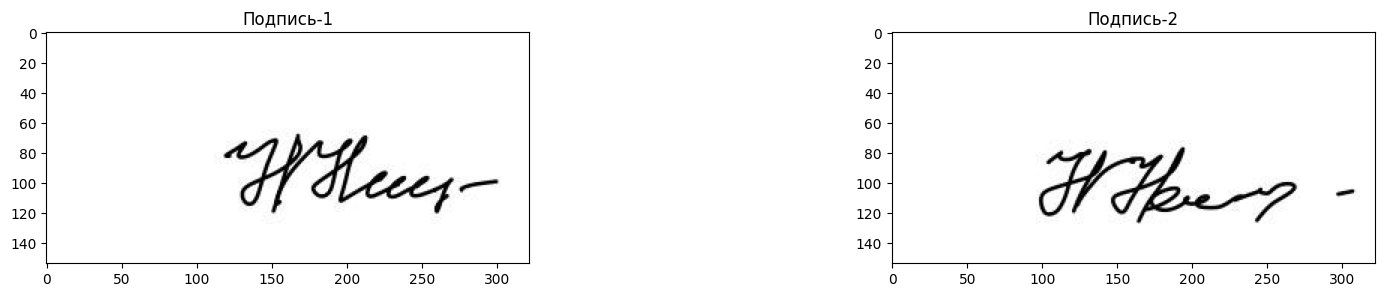

In [67]:
match_sign(test_false_1, test_false_0)